<a href="https://colab.research.google.com/github/dgallacher1/NotebookProjects/blob/main/SiPM_BreakdownVoltage/Read_IV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read the IV curves from Argon-1 board and fit breakdown voltages



*   In the first section of this analysis we calculate the breakdown voltage using the tangent method
*   The reverse IV curve is transformed to ln(I) vs V and two tangents are fit to the baseline region and rising region, the intercept of those two lines is the breakdown voltage

*   In the second section we use two methods for getting the maximum of the distribution of d ln(I)/dV, the first simply finds the maximum in the dlnI/dV array and maps the index to the voltage array, the makes a quartic spline and takes the cubic roots to determine the turning point of d ln(I)/dV plot to find the derivative, these methods agree well
*   An example fit is shown and the histogram of all breakdown voltages fit for this board, then the data is saved to a csv file for records





In [1]:
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 10]
import numpy as np
import numpy.polynomial as poly
from scipy.optimize import curve_fit

In [2]:
#Change here to run different file
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/IV/"

####################
#Change fname to run on other files
fname = "board_7"
####################

filename = "{}{}.csv".format(path,fname)
thedata = pd.read_csv(filename, sep=',')
thedata.head() 
#Check to make sure it's read properly

Mounted at /content/drive


,HV_set (V),HV_rdb (V),HV_err (V),VsCH_1 (V),VsCH_2 (V),VsCH_3 (V),VsCH_4 (V),VsCH_5 (V),VsCH_6 (V),VsCH_7 (V),VsCH_8 (V),VsCH_9 (V),VsCH_10 (V),VsCH_11 (V),VsCH_12 (V),VsCH_13 (V),VsCH_14 (V),VsCH_15 (V),VsCH_16 (V),IsCH_1 (A),IsCH_2 (A),IsCH_3 (A),IsCH_4 (A),IsCH_5 (A),IsCH_6 (A),IsCH_7 (A),IsCH_8 (A),IsCH_9 (A),IsCH_10 (A),IsCH_11 (A),IsCH_12 (A),IsCH_13 (A),IsCH_14 (A),IsCH_15 (A),IsCH_16 (A)
0,28.0,28.3218,0.00195,30.3216,30.3217,30.3216,30.3216,30.3218,30.3218,30.3217,30.3217,30.3217,30.3217,30.3216,30.3217,30.3217,30.3220,30.3218,30.3220,3.592170e-09,9.516870e-10,3.051760e-09,3.316010e-09,6.000200e-10,-7.053220e-10,2.402070e-09,9.536740e-10,2.298750e-09,1.217920e-09,3.721320e-09,1.913310e-09,1.025200e-09,-2.968310e-09,7.927420e-10,-3.073610e-09
1,28.3,28.6252,0.00260,30.6250,30.6251,30.6251,30.6252,30.6251,30.6252,30.6250,30.6253,30.6249,30.6252,30.6251,30.6250,30.6251,30.6254,30.6252,30.6253,3.552440e-09,1.905360e-09,1.239780e-09,4.172330e-10,1.263620e-09,2.443790e-10,2.962350e-09,-1.122550e-09,4.545850e-09,-3.973640e-12,1.994770e-09,2.771620e-09,1.353030e-09,-2.966320e-09,1.768270e-10,-1.450380e-09
2,28.6,28.9270,0.00235,30.9271,30.9268,30.9268,30.9270,30.9270,30.9270,30.9270,30.9270,30.9270,30.9268,30.9270,30.9270,30.9270,30.9269,30.9270,30.9270,-9.993710e-10,2.801420e-09,3.029900e-09,-5.563100e-11,1.788140e-10,3.298120e-10,-2.523260e-10,1.887480e-10,-5.702180e-10,3.588200e-09,6.914140e-10,7.967150e-10,-3.556410e-10,2.257030e-09,4.470350e-10,5.682310e-10
3,28.9,29.2280,0.00045,31.2279,31.2279,31.2279,31.2277,31.2282,31.2281,31.2280,31.2279,31.2280,31.2279,31.2281,31.2279,31.2281,31.2282,31.2282,31.2282,2.082190e-09,1.366930e-09,9.020170e-10,4.525980e-09,-2.857050e-09,-1.317260e-09,-3.337860e-10,8.742010e-10,7.530050e-10,1.575550e-09,-1.174210e-09,1.899400e-09,-2.475580e-09,-3.496810e-09,-3.902120e-09,-2.898770e-09
4,29.2,29.5303,0.00145,31.5302,31.5301,31.5302,31.5302,31.5302,31.5302,31.5304,31.5304,31.5301,31.5300,31.5302,31.5303,31.5305,31.5303,31.5304,31.5303,2.213320e-09,2.773600e-09,1.049040e-09,2.268950e-09,1.184150e-09,1.758340e-09,-2.135830e-09,-1.366930e-09,3.723300e-09,4.786250e-09,2.412000e-09,5.344550e-10,-4.037220e-09,7.748600e-11,-1.035130e-09,-1.211960e-10


Plot all the IV curves for illustration, we plot vs applied voltage since that's what we need to know for setting the voltage of the SiPM


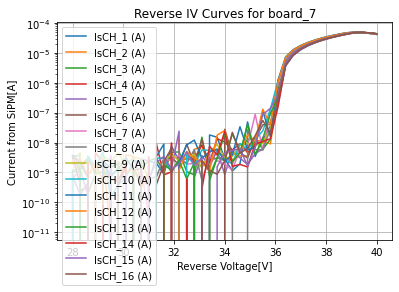

In [3]:
column_names = []
for name in thedata:
    column_names.append(name)
#Read current names
voltage_names = column_names[3:19] 
current_names = column_names[19:35] 
for name in current_names:
    plt.plot(thedata[column_names[0]],thedata[name],label='{}'.format(name))
    plt.xlabel('Reverse Voltage[V]')
    plt.ylabel('Current from SiPM[A]')
    plt.legend()
    plt.yscale('log')

#formatting
plt.grid()
plt.title("Reverse IV Curves for {}".format(fname))
plt.savefig('{}/Plots/Reverse_IV_{}.png'.format(path,fname))

Plot the ln(iSiPM), we then use these values and the linear tangent method from (Reference) to find the breakdown voltage


In [4]:
#function to return ln of a df column
def logarithm(col):
    #Incase we're negative, force it to be a small number instead
    return np.log(col,where=col>=0,out=np.log(np.full_like(col,1e-10)))

Text(0.5, 1.0, 'ln(I) vs Voltage Curves for /content/drive/My Drive/IV/board_7.csv')

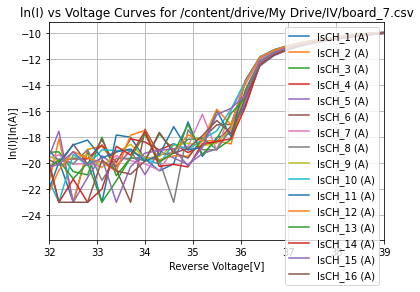

In [5]:
for index, name in enumerate(current_names):
    logC = (thedata[[name]]).apply(logarithm)
    logC_arr = logC.values
    logC_arr = logC_arr[:,0]
    dI = np.gradient(logC_arr)
    V = thedata[column_names[0]].values
    plt.plot(thedata[column_names[0]],logC_arr,label='{}'.format(name))
    plt.xlabel('Reverse Voltage[V]')
    plt.ylabel('ln(I)[ln(A)]')
    plt.legend()
    #plt.ylim(1e-3,1e2)
    #plt.yscale('log')
    plt.xlim(32,39)
    
plt.grid()
plt.title("ln(I) vs Voltage Curves for {}".format(filename))

Fit two lines to the data to determine V_Breakdown for illustration and testing
<br>
Simple linear fit function used below

In [6]:
#Linear fit y = a*x + b
def line_fit(valx,alpha,beta):
    return valx*alpha + beta

[35.8 36.1 36.4]
y1 = 8.73453 * x + -330.38094
y2 = 1.84153 * x + -82.37371
Breakdown voltage = 35.97958190721506 +/- 63.52262161215869


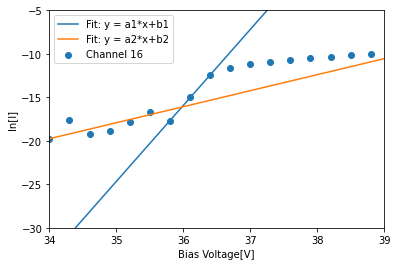

In [7]:
low_bound = [0,-10000]
high_bound = [100,100]
par = np.asarray([10.0,-20])
low_range = 35.5
high_range = 36.5
v2 = V[(low_range<V)&(V<high_range)]
print(v2)
i2 = logC_arr[(low_range<V)&(V<high_range)]
popt, cov = curve_fit(line_fit, v2,i2,p0=par,bounds=np.asarray([low_bound,high_bound]),absolute_sigma=True,sigma=0.1*v2)
a1, b1 = popt
perr1 = np.sqrt(np.diag(cov))
print('y1 = %.5f * x + %.5f' % (a1, b1))
low_range = 32.0
high_range = 35.0
v2 = V[(low_range<V)&(V<high_range)]
i2 = logC_arr[(low_range<V)&(V<high_range)]
#Do the second line
popt, cov = curve_fit(line_fit, v2,i2,p0=par,bounds=np.asarray([low_bound,high_bound]),absolute_sigma=True,sigma=0.1*v2)
a2, b2 = popt
perr2 = np.sqrt(np.diag(cov))
print('y2 = %.5f * x + %.5f' % (a2, b2))
plt.scatter(V,logC_arr,label="Channel {}".format(16))
plt.plot(V,line_fit(V,a1,b1),label="Fit: y = a1*x+b1")
plt.plot(V,line_fit(V,a2,b2),label="Fit: y = a2*x+b2")
plt.xlim(34,39)
plt.xlabel('Bias Voltage[V]')
plt.ylabel('ln[I]')
plt.ylim(-30,-5)
plt.legend()
e_Vb = np.sqrt(pow(((1/(a1-a2))*perr1[1]),2)+pow(((-1/(a1-a2))*perr2[1]),2)+pow(((b2-b1)/pow((a1-a2),2)*perr1[0]),2)+pow(((b2-b1)/pow((a1-a2),2)*perr2[0]),2))
Vb = (b2-b1)/(a1-a2)
print("Breakdown voltage = {} +/- {}".format(Vb,e_Vb))
plt.savefig('{}/Plots/testfit_BV_{}.png'.format(path,fname))

Loop over each channel and fit breakdown voltage using linear tangent method
<br>
Also plot the breakdown voltages found vs channel number

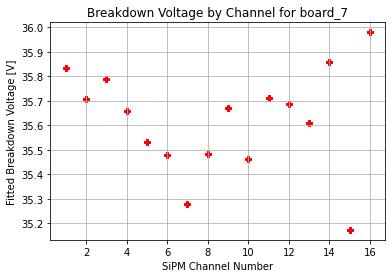

In [8]:
v_br = np.zeros(len(current_names))
v_e = np.zeros(len(current_names))

#Loop over current columns
for index, name in enumerate(current_names):
    #Some transformations to get a single array of the Ln(current values) for each column
    logC = (thedata[[name]]).apply(logarithm)
    logC_arr = logC.values
    logC_arr = logC_arr[:,0]
    #Same with votlages
    #V = thedata[voltage_names[index]].values
    V = thedata[column_names[0]].values

    #Bounds on parameters for fit
    low_bound = [0,-5000]
    high_bound = [100,100]
    par = np.asarray([10.0,-20])
    #Can't put a fit range into curvefit so slice the original array between the high and low range
    low_range = 35.5
    high_range = 36.5
    v2 = V[(low_range<V)&(V<high_range)]
    i2 = logC_arr[(low_range<V)&(V<high_range)]
    #Do the fit
    popt, cov = curve_fit(line_fit, v2,i2,p0=par,bounds=np.asarray([low_bound,high_bound]),absolute_sigma=True,sigma=0.1*v2)
    a1, b1 = popt
    perr1 = np.sqrt(np.diag(cov))
    #Repeat for second tangent line
    low_range = 32.0
    high_range = 35.0
    v2 = V[(low_range<V)&(V<high_range)]
    i2 = logC_arr[(low_range<V)&(V<high_range)]
    popt, cov = curve_fit(line_fit, v2,i2,p0=par,bounds=np.asarray([low_bound,high_bound]),absolute_sigma=True,sigma=0.1*v2)
    a2, b2 = popt
    #Calculate 1 sigma errors from parameter covariance matrix
    perr2 = np.sqrt(np.diag(cov))
    e_Vb = np.sqrt(pow(((1/(a1-a2))*perr1[1]),2)+pow(((-1/(a1-a2))*perr2[1]),2)+pow(((b2-b1)/pow((a1-a2),2)*perr1[0]),2)+pow(((b2-b1)/pow((a1-a2),2)*perr2[0]),2))
    #Calculate breakdown voltage and uncertainty
    Vb = (b2-b1)/(a1-a2)
    #Save to array
    v_br[index] = Vb
    v_e[index]= e_Vb

#Make plots
plt.scatter(np.arange(1,len(current_names)+1),v_br,marker='P',color='red')
#Not enough datapoints to get low uncertainties
#plt.errorbar(np.arange(1,len(current_names)+1),v_br,e_Vb)
plt.xlabel('SiPM Channel Number')
plt.ylabel('Fitted Breakdown Voltage [V]')
plt.title('Breakdown Voltage by Channel for {}'.format(fname))
plt.grid()
plt.savefig('{}/Plots/trend_BV_{}.png'.format(path,fname))

Plot histogram of breakdown voltages and print mean value and std dev.


Mean of the breakdown voltage distribution = 35.619210603043975
and std. dev. = 0.20528398420416374


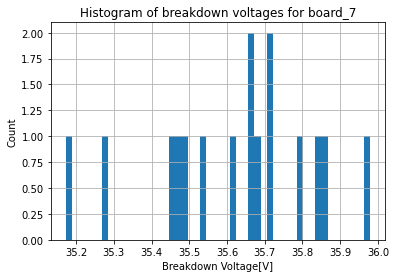

In [9]:
plt.hist(x=v_br,bins=50,)
plt.xlabel('Breakdown Voltage[V]')
plt.ylabel('Count')
plt.title('Histogram of breakdown voltages for {}'.format(fname))
plt.grid()

print("Mean of the breakdown voltage distribution = {}".format(v_br.mean()))
print("and std. dev. = {}".format(np.std(v_br)))
plt.savefig('{}/Plots/hist_BV_{}.png'.format(path,fname))

# Retry fits with Maximum from d ln(I)/dV

Text(0.5, 1.0, 'd[ln(I)]/dV vs Voltage Curves for /content/drive/My Drive/IV/board_7.csv')

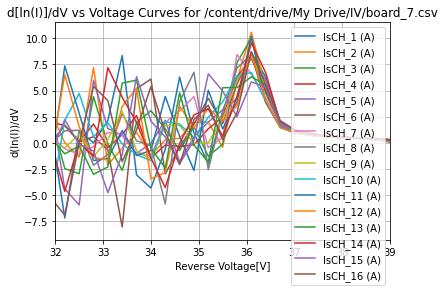

In [10]:
#Find the derivatives of the ln(iSiPM)
from scipy.interpolate import InterpolatedUnivariateSpline
der_max = np.zeros(len(current_names))
der_maxI = np.zeros(len(current_names))
der_max_spline = np.zeros(len(current_names))
der_max_splineI = np.zeros(len(current_names))

for index, name in enumerate(current_names):
    logC = (thedata[[name]]).apply(logarithm)
    logC_arr = logC.values
    logC_arr = logC_arr[:,0]
    dI = np.gradient(logC_arr)
    V = thedata[column_names[0]].values
    dV = np.gradient(V)
    dIdV = np.divide(dI,dV)
    #inv_dIdV = np.reciprocal(dIdV,where=dIdV>=0,out=np.zeros_like(dIdV))
    plt.plot(thedata[column_names[0]],dIdV,label='{}'.format(name))
    plt.xlabel('Reverse Voltage[V]')
    plt.ylabel('d(ln(I))/dV')
    plt.legend()
    #plt.ylim(1e-3,1e2)
    #plt.yscale('log')
    plt.xlim(32,39)

    #Restrict the scan for max to around the peak in derivative space and find voltage bin that has maxium dI/dV
    range_low = 35
    range_high = 38.2
    index_low = np.argmin(np.abs(np.array(V)-range_low))
    index_high = np.argmin(np.abs(np.array(V)-range_high))
    #print(dIdV)
    dIdV_cut = dIdV[index_low:index_high]
    index_max = np.argmin(np.abs(dIdV-dIdV_cut[np.argmax(dIdV_cut)]))
    der_max[index]=V[index_max]
    der_maxI[index]=dIdV[index_max]

    #Use splines instead
    f = InterpolatedUnivariateSpline(V[index_low:index_high], dIdV_cut, k=4) #The fourth order spline has cubic roots corresponding to maximum of a cubic spline interpolation
    max_pts = f.derivative().roots()
    #max_pts = np.append(max_pts, (V[0], V[-1]))  # also check the endpoints of the interval
    max_vals = f(max_pts)
    #print(max_vals)
    max_index = np.argmax(max_vals)
    der_max_spline[index]=max_pts[max_index]
    der_max_splineI[index]=max_vals[max_index]
    #print("Maximum value {} at {}".format(max_vals[max_index], max_pts[max_index]))

plt.grid()
plt.title("d[ln(I)]/dV vs Voltage Curves for {}".format(filename))

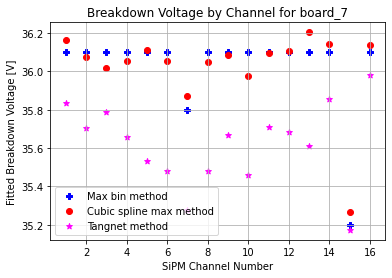

<Figure size 432x288 with 0 Axes>

In [11]:
#Plot the maximum in a range of values for each curve above 
plt.scatter(np.arange(1,len(current_names)+1),der_max,marker='P',color='blue',label='Max bin method')
plt.scatter(np.arange(1,len(current_names)+1),der_max_spline,marker='o',color='red',label='Cubic spline max method')
plt.scatter(np.arange(1,len(current_names)+1),v_br,marker='*',color='magenta',label='Tangnet method')
plt.xlabel('SiPM Channel Number')
plt.ylabel('Fitted Breakdown Voltage [V]')
plt.title('Breakdown Voltage by Channel for {}'.format(fname))
plt.legend()
plt.grid()
plt.show()
plt.savefig('{}/Plots/trend_derivative_BV_{}.png'.format(path,fname))

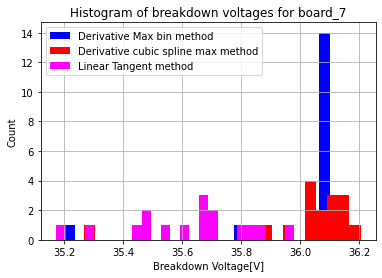

Mean breakdown (Max bin method) = 36.025000000000006
and std. dev. = 0.22499999999999995
Mean breakdown (Cubic Splines) = 36.02614114387809
and std. dev. = 0.20992189876471665


<Figure size 432x288 with 0 Axes>

In [12]:
plt.hist(x=der_max,bins=25,color='blue',label='Derivative Max bin method')
plt.hist(x=der_max_spline,bins=25,color='red',label='Derivative cubic spline max method')
plt.hist(x=v_br,bins=25,color='magenta',label='Linear Tangent method')
plt.xlabel('Breakdown Voltage[V]')
plt.ylabel('Count')
plt.title('Histogram of breakdown voltages for {}'.format(fname))
plt.grid()
plt.legend()
plt.show()

print("Mean breakdown (Max bin method) = {}".format(der_max.mean()))
print("and std. dev. = {}".format(np.std(der_max)))
print("Mean breakdown (Cubic Splines) = {}".format(der_max_spline.mean()))
print("and std. dev. = {}".format(np.std(der_max_spline)))
plt.savefig('{}/Plots/hist_derivative_BV_{}.png'.format(path,fname))

Compare the mean and standard deviations for 3 methods

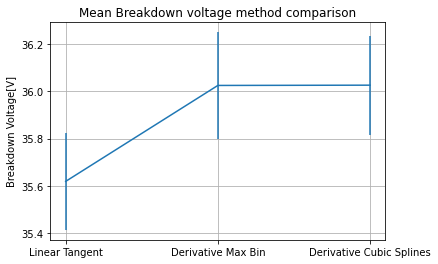

In [13]:
num_methods = 3
means = np.zeros(num_methods)
sdevs = np.zeros(num_methods)
x_axis = np.array([1,2,3])
x_labels = ['Linear Tangent','Derivative Max Bin','Derivative Cubic Splines']

means[0] = v_br.mean()
sdevs[0] = v_br.std()
means[1] = der_max.mean()
sdevs[1] = der_max.std()
means[2] = der_max_spline.mean()
sdevs[2] = der_max_spline.std()

#plot with custom x axis labels
plt.xticks(x_axis, x_labels)
plt.errorbar(x_axis,means,sdevs)
plt.title("Mean Breakdown voltage method comparison")
plt.ylabel("Breakdown Voltage[V]")
plt.grid()

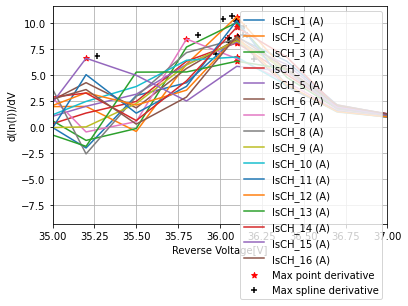

In [14]:
#Plot derivatives with max point marked for comparison
for index, name in enumerate(current_names):
    logC = (thedata[[name]]).apply(logarithm)
    logC_arr = logC.values
    logC_arr = logC_arr[:,0]
    dI = np.gradient(logC_arr)
    V = thedata[column_names[0]].values
    dV = np.gradient(V)
    dIdV = np.divide(dI,dV)
    #inv_dIdV = np.reciprocal(dIdV,where=dIdV>=0,out=np.zeros_like(dIdV))
    plt.plot(thedata[column_names[0]],dIdV,label='{}'.format(name))
    plt.xlabel('Reverse Voltage[V]')
    plt.ylabel('d(ln(I))/dV')
    #plt.ylim(1e-3,1e2)
    #plt.yscale('log')
    plt.xlim(35,37)
    
plt.scatter(der_max,der_maxI,color='red',marker='*',label="Max point derivative")
plt.scatter(der_max_spline,der_max_splineI,marker='+',color='black',label="Max spline derivative")
plt.grid()
plt.legend()


Print file out with breakdown voltages


In [15]:
hdrs = ['Channel Name','V_br(Tangent)[V]','V_br(Der Max Bin)[V]','V_br(Der Spline)[V]']
df = pd.DataFrame({'CName':current_names,'Vbr_tangent':v_br,'Vbr_der_maxbin':der_max,'Vbr_der_spline':der_max_spline})
df.to_csv('{}/breakdown_data_{}.csv'.format(path,fname), index=False,header=hdrs,mode='w')